<a href="https://colab.research.google.com/github/p42777/graph_conv_net/blob/main/gcn_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm 
from scipy.special import softmax
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from matplotlib import animation

In [3]:
def draw_kkl(nx_G, label_map, node_color, pos = None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k = 5/np.sqrt(nx_G.number_of_nodes()))
    nx.draw(nx_G, pos, with_labels = label_map is not None,  labels = label_map, node_color = node_color, ax = ax, **kwargs)

In [4]:
graph = nx.karate_club_graph()

# check nodes and edges
graph.number_of_nodes(), graph.number_of_edges()

(34, 78)

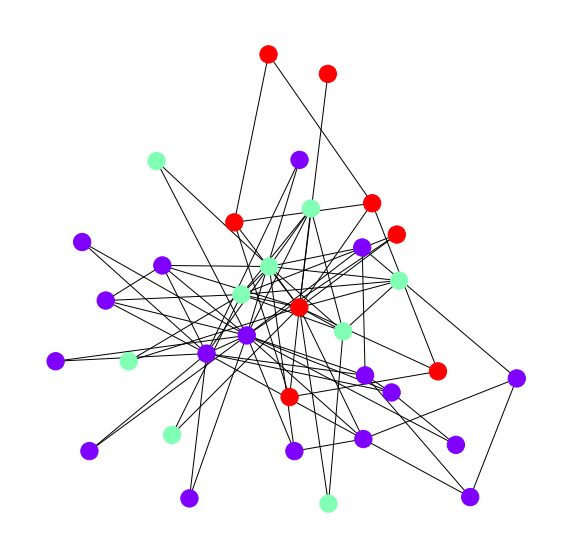

In [28]:
colors = np.zeros(graph.number_of_nodes())
for i, c in enumerate(greedy_modularity_communities(graph)):
    colors[list(c)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]
club_labels = nx.get_node_attributes(graph,'club')

kkl = draw_kkl(graph, None, colors, cmap = 'rainbow', edge_color = 'black')

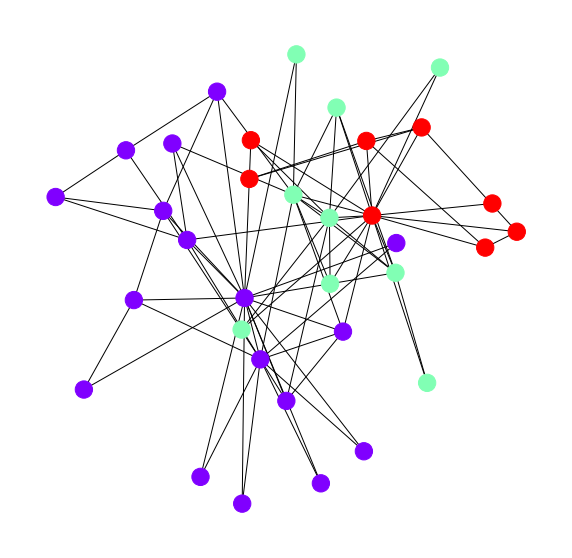

In [29]:
fig, ax = plt.subplots(figsize = (10,10))
pos = nx.spring_layout(graph, k=5/np.sqrt(graph.number_of_nodes()))
kwargs = {"cmap": 'rainbow', "edge_color":'black'}
nx.draw(graph, pos, with_labels = False, node_color = colors, ax = ax, **kwargs)

In [31]:
A = nx.to_numpy_matrix(graph) # adjadency matrix
print(A)

[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [33]:
A_tilde = A + np.eye(graph.number_of_nodes()) # self-connection
D_tilde = np.zeros_like(A_tilde)

np.fill_diagonal(D_tilde, np.asarray(A_tilde.sum(axis=1)).flatten()) # fill the main diaganal of D_tilde
D_tilde_inverse = np.linalg.inv(sqrtm(D_tilde)) # inverse sqruare-root
A_hat = D_tilde_inverse @ A_tilde @ D_tilde_inverse

X = np.eye(graph.number_of_nodes()) # input features

# **GCN Implementation**

In [38]:
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]

def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))

class GradDescentOptim():
    def __init__(self, lr, wd):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None
        
    def __call__(self, y_pred, y_true, train_nodes = None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.bs = self.train_nodes.shape[0]
        
    @property
    def out(self):
        return self._out
    
    @out.setter
    def out(self, y):
        self._out = y


class GCNLayer():
    def __init__(self, n_inputs, n_outputs, activation=None, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = name
        
    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
        
    def forward(self, A, X, W=None):
      
        self._A = A
        self._X = (A @ X).T # gradients
        
        if W is None:
            W = self.W
        
        H = W @ self._X # (h, D)*(D, bs) = (h, bs)
        if self.activation is not None:
            H = self.activation(H)
        self._H = H 
        return self._H.T # transpose to (bs, h)
    
    def backward(self, optim, update = True):
        dtanh = 1 - np.asarray(self._H.T)**2 # (bs, out_dim)
        d2 = np.multiply(optim.out, dtanh)  # (bs, out_dim) * element_wise * (bs, out_dim)
        
        self.grad = self._A @ d2 @ self.W # (bs, bs) * (bs, out_dim) * (out_dim, in_dim) = (bs, in_dim)     
        optim.out = self.grad
        
        dW = np.asarray(d2.T @ self._X.T) / optim.bs  # (out_dim, bs) * (bs, D) = (out_dim, D)
        dW_wd = self.W * optim.wd / optim.bs # update weight decay 
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr 
        
        return dW + dW_wd


class SoftmaxLayer():
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = name
        self._X = None 

    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def shift(self, proj):
        shiftx = proj - np.max(proj, axis=0, keepdims=True)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0, keepdims=True)
        
    def forward(self, X, W=None, b=None):
       
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = np.asarray(W @ self._X) + b # (out, h) * (h, bs) = (out, bs)
        return self.shift(proj).T # (bs, out)
    
    def backward(self, optim, update=True):
        
        # mask on loss
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        d1 = np.asarray((optim.y_pred - optim.y_true)) # (bs, out_dim)
        d1 = np.multiply(d1, train_mask) # (bs, out_dim) with loss of non-train nodes set to zero
        
        self.grad = d1 @ self.W # (bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        optim.out = self.grad
        
        dW = (d1.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, in_dim) = (out_dim, in_dim)
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs # (out_dim, 1)
                
        dW_wd = self.W * optim.wd / optim.bs # update weight decay 
        
        if update:   
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
        
        return dW + dW_wd, db.reshape(self.b.shape)

In [41]:
gcn1 = GCNLayer(graph.number_of_nodes(), 2, activation=np.tanh, name='1')
sm1 = SoftmaxLayer(2, n_classes, "SM")
opt = GradDescentOptim(lr = 0, wd = 1.0)
gcn1_out = gcn1.forward(A_hat, X)
opt(sm1.forward(gcn1_out), labels)

# **The GCN Model**

In [49]:
class GCNNetwork():
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes, activation, seeding = 0):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        np.random.seed(seeding) # seeding
        self.layers = list()
        
        # Input Layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)
        
        # Hidden Layer
        for layer in range(n_layers):
            gcn = GCNLayer(self.layers[-1].W.shape[0], hidden_sizes[layer], activation, name=f'h{layer}')
            self.layers.append(gcn)
            
        # Output Layer
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.layers.append(sm_out)
        
    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])
    
    def embedding(self, A, X):
        H = X
        for layer in self.layers[:-1]:
            # loop through all  layers
            H = layer.forward(A, H)
        return np.asarray(H)
    
    def forward(self, A, X):
        H = self.embedding(A, X)
        p = self.layers[-1].forward(H)
        return np.asarray(p)

In [50]:
gcn_model = GCNNetwork(n_inputs = graph.number_of_nodes(), n_outputs = n_classes, n_layers = 2, hidden_sizes = [16, 2], activation = np.tanh, seeding = 100)
gcn_model

GCN: W_in (34, 16)
GCN: W_h0 (16, 16)
GCN: W_h1 (16, 2)
Softmax: W_sm (2, 3)

In [51]:
y_pred = gcn_model.forward(A_hat, X)
embed = gcn_model.embedding(A_hat, X)
xent(y_pred, labels).mean()

1.0759636138197173

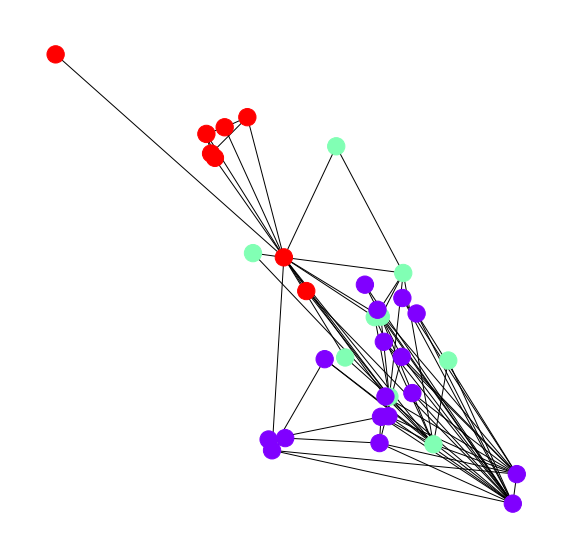

In [56]:
pos = {i: embed[i,:] for i in range(embed.shape[0])}
f_kkl = draw_kkl(graph, None, colors, pos = pos, cmap = 'rainbow', edge_color = 'black')

# **Training**

In [66]:
train_nodes = np.array([0, 1, 8])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
opt2 = GradDescentOptim(lr = 2e-2, wd = 2.5e-2)

In [69]:
embeddings = list()
accuracy = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
est_iterations = 0
est_steps = 50

for epoch in range(15000):
    
    y_pred = gcn_model.forward(A_hat, X)
    opt2(y_pred, labels, train_nodes)
   
    for layer in reversed(gcn_model.layers):
        layer.backward(opt2, update = True)
        
    embeddings.append(gcn_model.embedding(A_hat, X))
    # Accuracy for non-training nodes
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accuracy.append(acc.mean())
    
    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    if loss_test < loss_min:
        loss_min = loss_test
        est_iterations = 0
    else:
        est_iterations += 1
        
    if est_iterations > est_steps:
        print("Early stopped!")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")
        
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)
accuracy[-1]

Epoch: 1, Train Loss: 0.080, Test Loss: 0.353
Epoch: 101, Train Loss: 0.077, Test Loss: 0.353
Epoch: 201, Train Loss: 0.075, Test Loss: 0.353
Epoch: 301, Train Loss: 0.073, Test Loss: 0.353
Epoch: 401, Train Loss: 0.072, Test Loss: 0.353
Epoch: 501, Train Loss: 0.070, Test Loss: 0.353
Epoch: 601, Train Loss: 0.069, Test Loss: 0.352
Epoch: 701, Train Loss: 0.068, Test Loss: 0.352
Epoch: 801, Train Loss: 0.067, Test Loss: 0.352
Epoch: 901, Train Loss: 0.066, Test Loss: 0.351
Epoch: 1001, Train Loss: 0.065, Test Loss: 0.351
Epoch: 1101, Train Loss: 0.064, Test Loss: 0.351
Epoch: 1201, Train Loss: 0.064, Test Loss: 0.350
Epoch: 1301, Train Loss: 0.063, Test Loss: 0.350
Epoch: 1401, Train Loss: 0.063, Test Loss: 0.350
Epoch: 1501, Train Loss: 0.062, Test Loss: 0.349
Epoch: 1601, Train Loss: 0.062, Test Loss: 0.349
Epoch: 1701, Train Loss: 0.061, Test Loss: 0.348
Epoch: 1801, Train Loss: 0.061, Test Loss: 0.348
Epoch: 1901, Train Loss: 0.061, Test Loss: 0.347
Epoch: 2001, Train Loss: 0.060, 

0.8709677419354839

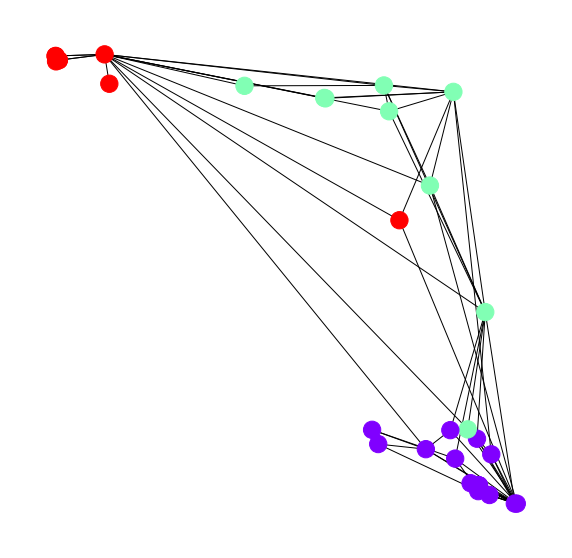

In [71]:
pos = {i: embeddings[-1][i,:] for i in range(embeddings[-1].shape[0])}
f_kkl2 = draw_kkl(graph, None, colors, pos = pos, cmap = 'rainbow', edge_color = 'black')

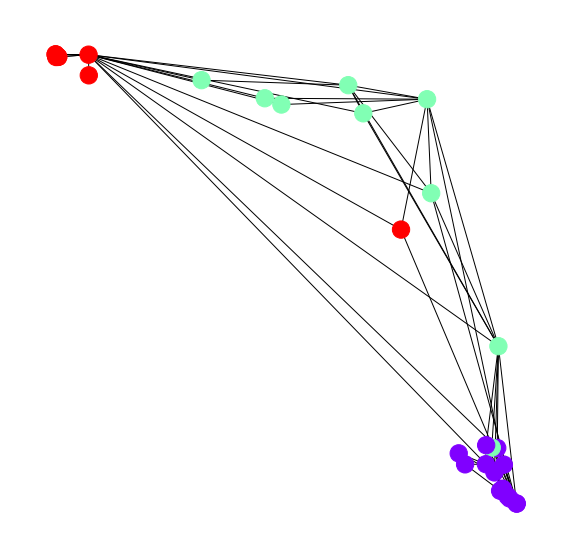

In [75]:
N = 500
snapshots = np.linspace(0, len(embeddings)-1, N).astype(int)
fig, ax = plt.subplots(figsize=(10, 10))
kwargs = {'cmap': 'rainbow', 'edge_color': 'black', }

def update(idx):
    ax.clear()
    embeddings2 = embeddings[snapshots[idx]]
    pos = {i: embeddings2[i,:] for i in range(embeddings2.shape[0])}
    nx.draw(graph, pos, node_color = colors, ax = ax, **kwargs)

anim = animation.FuncAnimation(fig, update, frames = snapshots.shape[0], interval = 10, repeat = False)